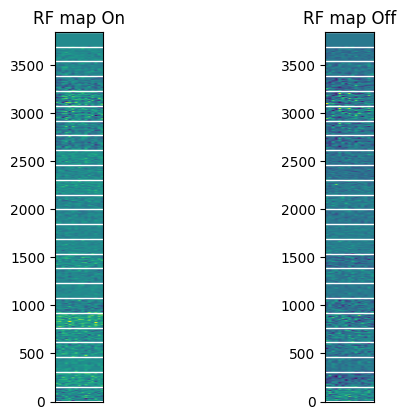

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from one.api import ONE

import brainbox.io.one as bbone
import brainbox.task.passive as passive

eid = '4ecb5d24-f5cc-402c-be28-9d0f7cb14b3a'
probe = 'probe00'
one = ONE(base_url='https://openalyx.internationalbrainlab.org', silent=True)
one = ONE(password='international')
# Load in the receptive field map data
rf_map = bbone.load_passive_rfmap(eid, one=one)
spike_times = one.load_dataset(eid, dataset='spikes.times.npy', collection=f'alf/{probe}')
spike_depths = one.load_dataset(eid, dataset='spikes.depths.npy', collection=f'alf/{probe}')
# Remove any nan depths
kp_idx = np.where(~np.isnan(spike_depths))[0]
spike_times = spike_times[kp_idx]
spike_depths = spike_depths[kp_idx]
# Pass this data into brainbox function to find out at what times each voxel on screen was
# activated
rf_stim_times, rf_stim_pos, rf_stim_frames = passive.get_on_off_times_and_positions(rf_map)

# rf_stim_times - time of frame change
# rf_stim_pos - position of each voxel on (15 x 15) screen
# rf_stim_frames - frames at which stimulus was turned 'on' (grey to white) or 'off' (grey to
#                   black) at each position on screen

# For each position on screen compute average stim epoched activity across depth of probe
rf_map_avg, _ = passive.get_rf_map_over_depth(rf_stim_times, rf_stim_pos, rf_stim_frames,
                                              spike_times, spike_depths, t_bin=0.01,
                                              d_bin=160, pre_stim=0.05, post_stim=1.5)

# Take the SVD across to represent RF map across depth
rf_svd = passive.get_svd_map(rf_map_avg)

# Now we can plot the RF map for the on and off response
on_rf_map = np.vstack(rf_svd['on'])
off_rf_map = np.vstack(rf_svd['off'])

fig, ax = plt.subplots(1, 2)
depths = np.linspace(0, 3840, len(rf_svd['on']) + 1)
ax[0].imshow(on_rf_map, extent=(0, 500, 0, 3840), origin='lower')
ax[0].hlines(depths, *ax[0].get_xlim(), linewidth=1, colors='w')
ax[0].get_xaxis().set_visible(False)
ax[0].set_title('RF map On')
ax[1].imshow(off_rf_map, extent=(0, 500, 0, 3840), origin='lower')
ax[1].hlines(depths, *ax[1].get_xlim(), linewidth=1, colors='w')
ax[1].get_xaxis().set_visible(False)
ax[1].set_title('RF map Off')
plt.show()